In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

approaches = ["a", "e", "p"]
replicas_num = 3

test_data_set_codes_general = ["cpu-stress", "mem-leak", "pack-loss", "pack-delay", "pack-corr"]
test_data_set_code_for_fpr_test = "fpr-validation"

# Set of lists with the experiments schedules - [whole duration, fault injection point, failre point]
data_sets_config = {"normal_24h": [1440, 0, 0], "normal_15_21": [10080, 0, 0],
                    "cpu-stress-0": [45, 16, 42], "mem-leak-0": [60, 16, 51], "pack-loss-0": [30, 16, 25], "pack-delay-0": [30, 16, 25], "pack-corr-0": [30, 16, 24],
                    "cpu-stress-1": [45, 16, 40], "mem-leak-1": [60, 16, 43], "pack-loss-1": [30, 16, 22], "pack-delay-1": [30, 16, 24], "pack-corr-1": [30, 16, 28],
                    "cpu-stress-2": [45, 16, 42], "mem-leak-2": [60, 16, 49], "pack-loss-2": [30, 16, 23], "pack-delay-2": [30, 16, 23], "pack-corr-2": [30, 16, 25]}


# Path to the .csv file to save the AE point-level predictions
predictions_file_path = "resources/predictions-{approach}/{data_set_code}.csv"

# Path to the .txt file to save the localisations (output of the Anomaly Ranker)
localisations_file_path = "resources/localisations/{data_set_code}.csv"


cluster_node_pairs_string = 'redis-1-1 redis-1-12, redis-1-2 redis-1-13, redis-1-3 redis-1-14, redis-1-4 redis-1-15, redis-1-5 redis-1-16, redis-1-6 redis-1-17, redis-1-7 redis-1-18, redis-1-8 redis-1-19, redis-1-9 redis-1-20, redis-1-10 redis-1-11'

# Create a list of the cluster's nodes pairs - cluster_node_pairs
cluster_node_pairs = cluster_node_pairs_string.split(", ")
for ii in range(len(cluster_node_pairs)):
    cluster_node_pairs[ii] = cluster_node_pairs[ii].split(" ")
    
    
    
def get_prediction(history, time_point, period):
    if time_point < period - 1:
        cache = []
        prediction = 0
    else:
        cache = [history[time_point - ii] for ii in range(period)]

        if cache.count(cache[0]) == len(cache):
            prediction = 1
        else:
            prediction = 0
    
    return prediction

Each plot shows the prediction and localization results of the approaches in application to different types of failures (CPU Stress, Memory Loss, Network packet loss, Network packet delay, Network packet corruption)
Each plot contains 9 lines. Each line reflects the results of different approachs on different experimental replica.
Lines from to the bottom to the top: 
 - Prevent-A Replica 0 
 - Prevent-A Replica 1 
 - Prevent-A Replica 2 
 - Prevent-E Replica 0 
 - Prevent-E Replica 1 
 - Prevent-E Replica 2 
 - Premise Replica 0 
 - Premise Replica 1 
 - Premise Replica 2 

Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:
 - Yellow: No predition 
 - Light blue: False positive predition or true positive prediciton without correct localization 
 - Blue: True positive prediciton with correct localization 
 - Red: system crash/disruption 

Vertical red line depicts the failure injection moment


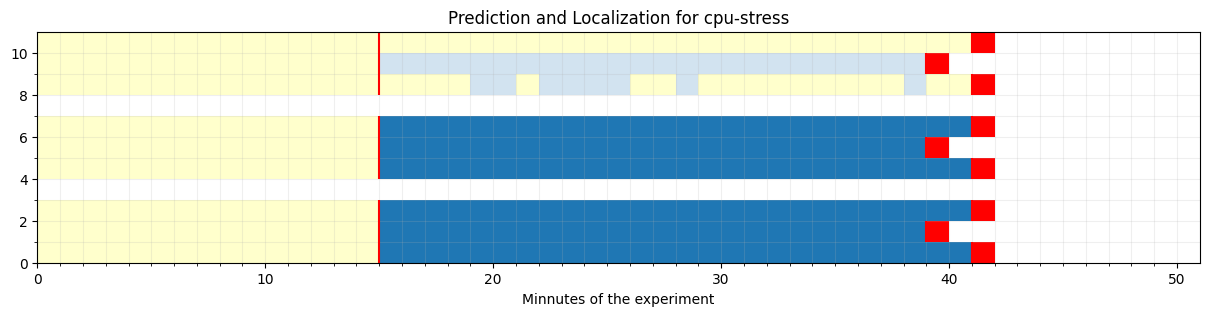

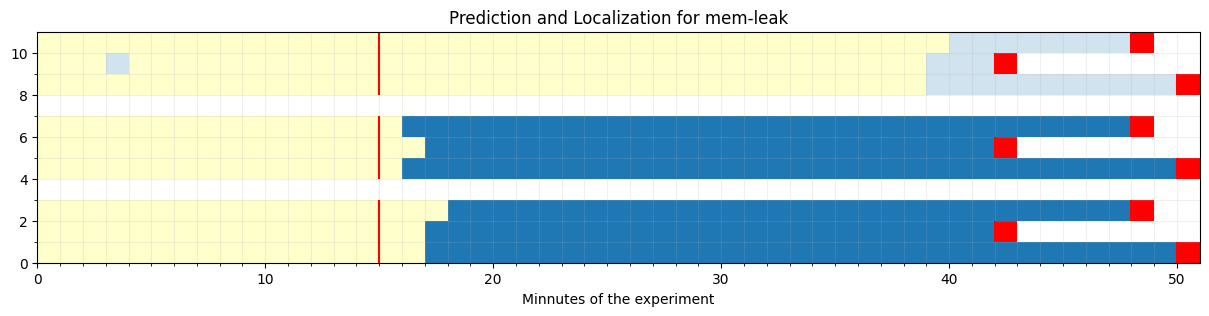

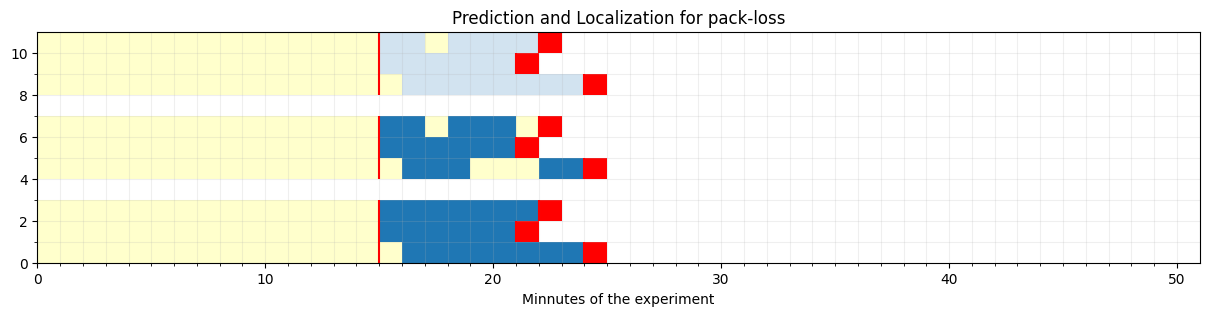

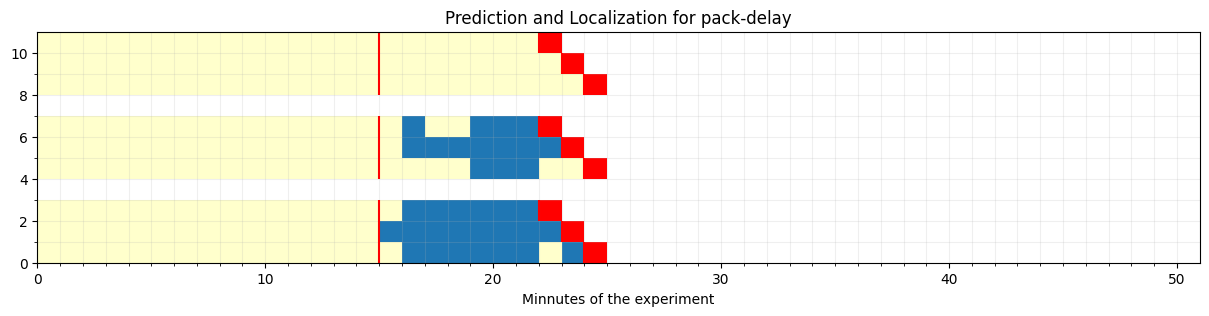

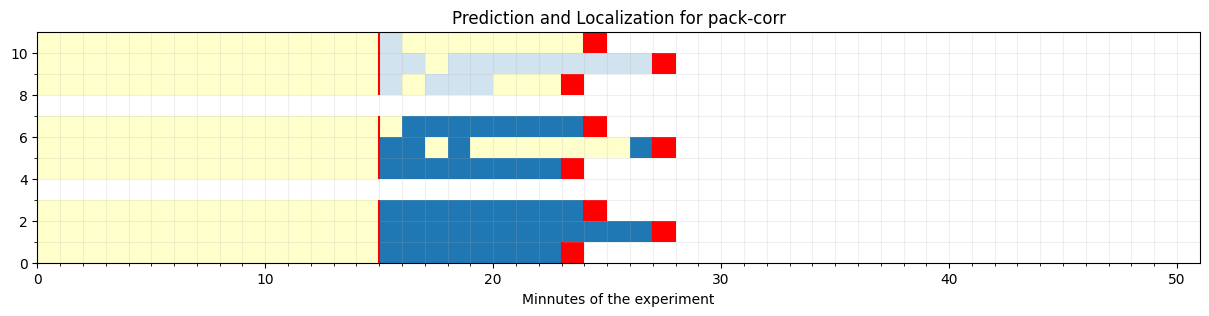

In [2]:
#### Predictions/Localizations Visualisation

print("Each plot shows the prediction and localization results of the approaches in application to different types of failures (CPU Stress, Memory Loss, Network packet loss, Network packet delay, Network packet corruption)")
print("Each plot contains 9 lines. Each line reflects the results of different approachs on different experimental replica.")
print("Lines from to the bottom to the top:", "\n"
      " - Prevent-A Replica 0", "\n"
      " - Prevent-A Replica 1", "\n"
      " - Prevent-A Replica 2", "\n"
      " - Prevent-E Replica 0", "\n"
      " - Prevent-E Replica 1", "\n"
      " - Prevent-E Replica 2", "\n"
      " - Premise Replica 0", "\n"
      " - Premise Replica 1", "\n"
      " - Premise Replica 2", "\n"
     )
print("Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:")
print(
      " - Yellow: No predition", "\n"
      " - Light blue: False positive predition or true positive prediciton without correct localization", "\n"
      " - Blue: True positive prediciton with correct localization", "\n"
      " - Red: system crash/disruption", "\n"
     )
print("Vertical red line depicts the failure injection moment")

for general_code in test_data_set_codes_general:

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.set_title("Prediction and Localization for " + general_code)
    ax.set_xlabel("Minnutes of the experiment")
    ax.set_xlim([1, 51])
    ax.set_ylim([0, 11], auto=False)
    minor_ticks_x = np.arange(0, 51, 1)
    minor_ticks_y = np.arange(0, 11, 1)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='both', alpha=0.2)

    for approach_idx, approach in enumerate(approaches):
        for replication in range(replicas_num):
            
            if replication == 0:
                faulty_pair_index = 9
                
            if replication == 1:
                faulty_pair_index = 1
                
            if replication == 2:
                faulty_pair_index = 2
                
                if general_code == "pack-delay":
                    faulty_pair_index = 1
                
            faulty_master = cluster_node_pairs[faulty_pair_index][0]
            faulty_slave = cluster_node_pairs[faulty_pair_index][1]
            
            test_data_set_code = "{code}-{replica}".format(code=general_code, replica=replication) 
                
            # Load predictions
            with open(predictions_file_path.format(data_set_code=test_data_set_code, approach=approach), newline='') as csvfile:
                csv_reader = csv.reader(csvfile)
                predictions = [int(row[0]) for row in csv_reader]

            # Load localizations. 1 if the one of the faulty nodes is in top 1, 0 otherwise
            with open(localisations_file_path.format(data_set_code=test_data_set_code), "r") as file_in:
                csv_reader = csv.reader(file_in, delimiter=',')

                localizations = []
                for row in csv_reader:
                    
                    top_1 = ""
                    top_2 = ""
                    top_3 = ""
                    rank_1 = 0
                    rank_2 = 0
                    rank_3 = 0
                    top_list = []
                    
                    if len(row) > 2:
                        top_1 = row[2]
                        rank_1 = row[3]
                        
                    if len(row) > 4:
                        top_2 = row[4]
                        rank_2 = row[5]
                        
                    if len(row) > 6:
                        top_3 = row[6]
                        rank_3 = row[7]

                    if top_1 != "":
                        if rank_1 == rank_2 == rank_3:
                            top_list = [top_1, top_2, top_3]
                        else:        
                            if rank_1 == rank_2:
                                top_list = [top_1, top_2]
                            else:
                                top_list = [top_1]

                    if faulty_master in top_list or faulty_slave in top_list:
                        localizations.append(1)
                    else:
                        localizations.append(0)
            
            fi_point = data_sets_config[test_data_set_code][1]
            fa_point = data_sets_config[test_data_set_code][2]
            
            predictions = predictions[:fa_point - 1]
            localizations = localizations[:fa_point - 1]

            line_shift = (approach_idx * (replicas_num + 1)) + replication

            ax.vlines(fi_point - 1, line_shift + 1, line_shift, color="red")
            ax.vlines(fa_point - 1, line_shift + 1, line_shift, color="red")

            for time_point, prediction in enumerate(predictions):
                
                if approach == "p":
                    if prediction == 0:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)
                    
                    if prediction == 1:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.2)
                    
                    if prediction == 2:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1)
                else:
                    localization = localizations[time_point]

                    if prediction == 1:
                        if localization == 1:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1)
                        else:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.2)
                    else:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)
                        
            ax.broken_barh([(time_point + 1, 1)], (line_shift, 1.0), facecolors=('red'), alpha=1)

In [3]:
# -- FPR of LOUD

print("False positive rate of prediction with Loud on a one week of normal data. The point is considered anomalous when the same node persists in the top of nodes that LOUD ranks as anomalous for N consecutive timestamps.", "\n")

# Read the raw localisations matrix - vectors like [0, 1, 0] where [None, Weak, Strong] localisations.
localisations_file_reader = csv.reader(open(localisations_file_path.format(data_set_code=test_data_set_code_for_fpr_test), 'r'))
top_nodes = [row[2] if len(row) >= 3 else "" for idx, row in enumerate(localisations_file_reader)]

for period in range(3, 7):
    predictions = [get_prediction(top_nodes, time_point, period) for time_point in range(len(top_nodes))]
    FPR = round(sum(predictions) * 100 / len(predictions))
    print("LOUD N =", period, ":", FPR, "%")

False positive rate of prediction with Loud on a one week of normal data. The point is considered anomalous when the same node persists in the top of nodes that LOUD ranks as anomalous for N consecutive timestamps. 

LOUD N = 3 : 57 %
LOUD N = 4 : 43 %
LOUD N = 5 : 32 %
LOUD N = 6 : 22 %


In [4]:
# -- FPR of Prevent

print("False positive rate of prediction with Prevent on a one week of normal data:", "\n")

approaches = ["a", "e", "p"]

for approach_idx, approach in enumerate(approaches):
    
    if approach == "p":
        continue
    
    if approach == "a":
        approach_name = "Prevent-A"
        
    if approach == "e":
        approach_name = "Prevent-E"

    # Load predictions
    with open(predictions_file_path.format(data_set_code=test_data_set_code_for_fpr_test, approach=approach), newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        predictions = [int(row[0]) for row in csv_reader]
        
    FPR = round(sum(predictions) * 100 / len(predictions))
    
    print(approach_name, ":", FPR, "%")
    

False positive rate of prediction with Prevent on a one week of normal data: 

Prevent-A : 2 %
Prevent-E : 5 %
